Distributed Source Coding for Machine Learning
==============================================

## Compare one and two stage encoders

In [1]:
from dsc4ml.encoders import LocalEncoder, DistributedEncoder
from dsc4ml.decoders import FusionDecoder
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = [9, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'Dark2'


def generate_2d_dataset(n, ρ=0.0):
    μ = [1, 0]
    Σ = [[1, ρ],
         [ρ, 1]]
    X = np.random.multivariate_normal(μ, Σ, size=n)
    X = xr.DataArray(X, dims=['n', 'd'])
    return X


def sample(A, dim, size):
    i_sample = np.random.randint(A[dim].size, size=size)
    return A[i_sample]

### One-stage (prototypes $=$ codebook)

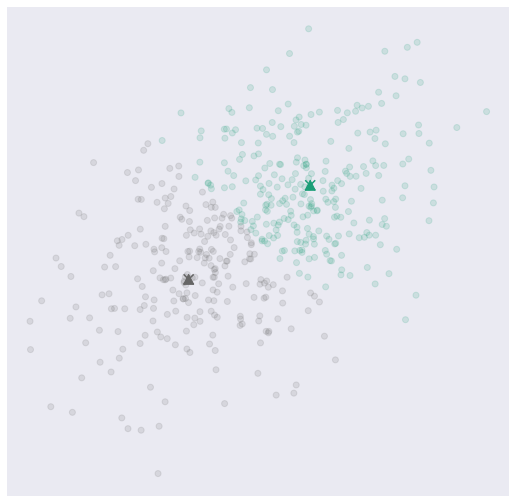

In [2]:
np.random.seed(0)

X = generate_2d_dataset(500, ρ=0.5)
codebook = sample(X, 'n', 2).rename(n='m')
protos = codebook.rename(m='p')

enc = LocalEncoder(protos)
dec = FusionDecoder(codebook)

for i in range(10):
    dec = dec.optimize(X, enc)
    enc = LocalEncoder(dec.codebook.rename(m='p'))

plt.scatter(*enc.protos.T, c=enc(enc.protos.rename(p='n')), marker='x', s=100)
plt.scatter(*dec.codebook.T, c=enc(dec.codebook), marker='^', s=100)
plt.scatter(*X.T, c=enc(X), alpha=0.15)
plt.xticks([])
plt.yticks([])
plt.show()

### Two-stage (prototypes $\neq$ codebook)

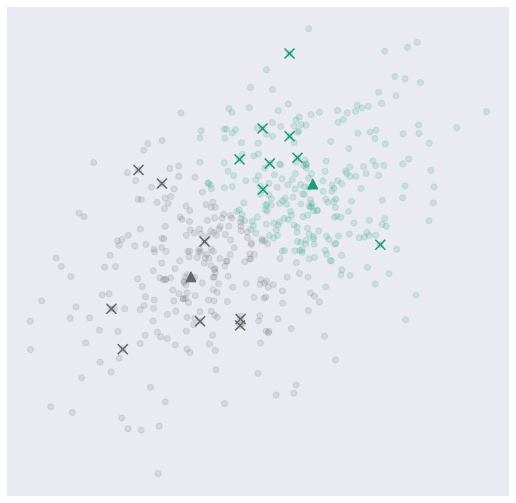

In [3]:
np.random.seed(0)

p = 16 
X = generate_2d_dataset(500, ρ=0.5)
protos = sample(X, 'n', p).rename(n='p')
q_indices = xr.DataArray(np.random.randint(2, size=p), dims='p')
codebook = sample(X, 'n', 2).rename(n='m')

enc = LocalEncoder(protos, q_indices)
dec = FusionDecoder(codebook)

for i in range(10):
    dec = dec.optimize(X, enc)
    enc = enc.optimize(X, dec)

plt.scatter(*enc.protos.T, c=enc(enc.protos.rename(p='n')), marker='x', s=100)
plt.scatter(*dec.codebook.T, c=enc(dec.codebook), marker='^', s=100)
plt.scatter(*X.T, c=enc(X), alpha=0.15)
plt.xticks([])
plt.yticks([])
plt.show()

## Two-stage Distributed Encoders

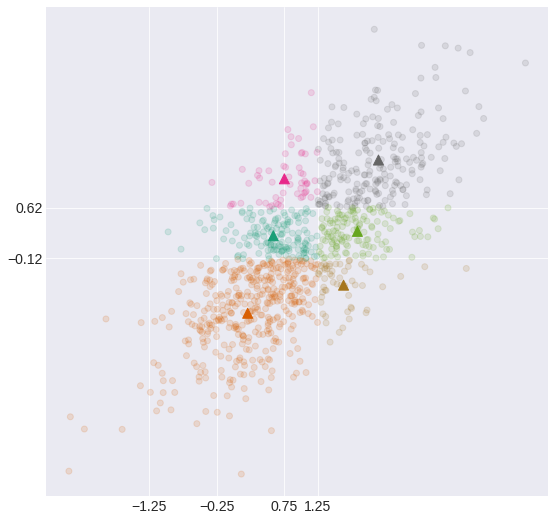

In [4]:
np.random.seed(5)

X = generate_2d_dataset(1_000, ρ=0.7)
encoders = [LocalEncoder(xr.DataArray([[-1.5, -1.0, 0.5, 1.0, 1.5]], dims=['d', 'p']),
                         xr.DataArray([1, 0, 1, 0, 1], dims='p')),
            LocalEncoder(xr.DataArray([[-0.5, 0.25, 1.0]], dims=['d', 'p']),
                         xr.DataArray([1, 0, 2], dims='p'))]

enc = DistributedEncoder(encoders)
dec = FusionDecoder.init_from_encoder(X, enc)

for i in range(10):
    enc = enc.optimize(X, dec)
    dec = dec.optimize(X, enc)

plt.scatter(*dec.codebook.T, c=enc(dec.codebook), marker='^', s=100)
plt.scatter(*X.T, c=enc(X), alpha=0.15)
plt.xticks(enc[0].boundaries.round(2))
plt.yticks(enc[1].boundaries.round(2))
plt.show()

```{toctree}
:hidden:
:titlesonly:


.pytest_cache/README
dsc4ml/decoders
```